# **Image Steganography**

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from skimage.io import imread, imshow
from skimage.transform import rescale
import skimage
import bitarray
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

/kaggle/input/star-wars-steganography-images/Death-Star.jpg
/kaggle/input/star-wars-steganography-images/R2D2.jpg
/kaggle/input/star-wars-steganography-images/death_star_HD.jpg
/kaggle/input/star-wars-steganography-images/x-wing.jpg
/kaggle/input/star-wars-steganography-images/Phantom_Menace_Trailer.mp4
/kaggle/input/star-wars-steganography-images/Empire_Strikes_Back _Trailer.mp4
/kaggle/input/star-wars-steganography-images/Deathstar_blueprint.jpg
/kaggle/input/star-wars-steganography-images/x-wing-HD.jpg
/kaggle/input/star-wars-movie-scripts/SW_EpisodeV.txt
/kaggle/input/star-wars-movie-scripts/SW_EpisodeVI.txt
/kaggle/input/star-wars-movie-scripts/SW_EpisodeIV.txt
/kaggle/input/star-wars-movie-scripts/wordcloud_masks/r2d2.png
/kaggle/input/star-wars-movie-scripts/wordcloud_masks/vader.png
/kaggle/input/star-wars-movie-scripts/wordcloud_masks/rebel alliance.png
/kaggle/input/star-wars-movie-scripts/wordcloud_masks/yoda.png
['star-wars-steganography-images', 'star-wars-movie-scripts']


*Star-Wars-Script is read from all 3 files in star-wars-movie-scripts dataset. It is then cleaned and combined into a single string, All_SW_Scripts.*

In [2]:
All_SW_Scripts = ""

def TextToString(txt):
    with open (txt, "r") as file:
        data=file.readlines()
        script = ""
        for x in data[1:]:
            x = x.replace('"','').replace("\n"," \n ").split(' ')
            x[1] += ":"
            script += " ".join(x[1:-1]).replace("\n"," \n ")
        return script
All_SW_Scripts += TextToString("../input/star-wars-movie-scripts/SW_EpisodeIV.txt")
All_SW_Scripts += TextToString("../input/star-wars-movie-scripts/SW_EpisodeV.txt")
All_SW_Scripts += TextToString("../input/star-wars-movie-scripts/SW_EpisodeVI.txt")
print(All_SW_Scripts[:1000])

THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  
 THREEPIO: We're doomed!  
 THREEPIO: There'll be no escape for the Princess this time.  
 THREEPIO: What's that?  
 THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  
 LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  
 THREEPIO: Artoo! Artoo-Detoo, where are you?  
 THREEPIO: At last!  Where have you been?  
 THREEPIO: They're heading in this direction. What are we going to do?  We'll be sent to the spice mines of Kessel or smashed into who knows what!  
 THREEPIO: Wait a minute, where are you going?  
 IMPERIAL: OFFICER The Death Star plans are not in the main computer.  
 VADER: Where are those transmissions you intercepted?  
 REBEL: OFFICER We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission.  
 VADER: If this is a consular ship... wh

Image is 559 by 561 pixels with 3 color channels


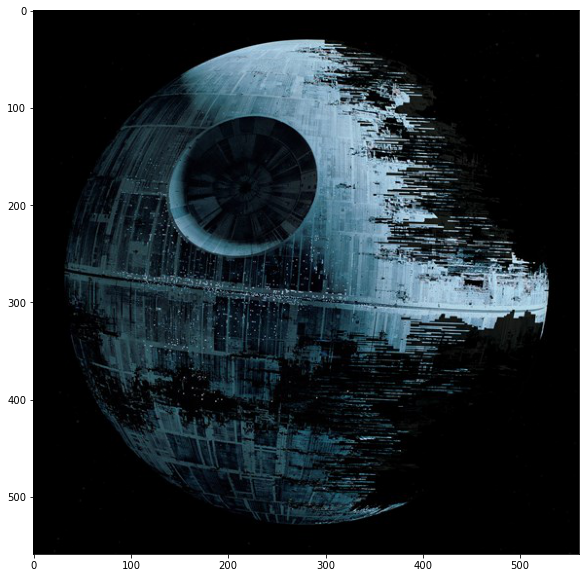

In [3]:
deathstar_img = imread("../input/star-wars-steganography-images/Death-Star.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(deathstar_img)

print("Image is "+str(deathstar_img.shape[0])+" by "+str(deathstar_img.shape[1])+" pixels with "+str(deathstar_img.shape[2])+" color channels")

*The following function converts the string All_SW_Scripts to bits.*

In [4]:
def MessageToBits(message):
    #tag message (and pad w/ spaces till 10 characters)
    tag = "{:<10}".format(str(len(message)*8))
    message = tag+message
    #convert to bits
    code = bitarray.bitarray()
    code.frombytes(message.encode('utf-8'))
    code = "".join(['1' if x == True else '0' for x in code.tolist()])
    return code

*The following function finds the bit size of message and checks if it can fit in the image.*

In [5]:
def CheckBitSize(img, message):
    h = img.shape[0]
    w = img.shape[1]
    try:
        c = img.shape[2]
    except:
        c = 1
    image_max_size = h*w*c*2
    string_size = len(message)
    print("Message is "+str(string_size/8000)+" KB and image can fit "+str(image_max_size/8000)+" KB of data")
    if string_size > image_max_size:
        print("Message is too big to be encoded in image")
        return False
    else:
        print("Image can be encoded with message. Proceed")
        return True
    
CheckBitSize(deathstar_img, MessageToBits(All_SW_Scripts))

Message is 167.047 KB and image can fit 235.19925 KB of data
Image can be encoded with message. Proceed


True

*The following message encodes the message into the image using LSB Algorithm.*

In [6]:
%%time
def EncodeImage(img, message):
    code = MessageToBits(message)
    if CheckBitSize(img, code):
        shape = img.shape
        img = img.flatten()
        code = list(code)
        code_len = len(code)
        for i,x in enumerate(img):
            if i*2 <code_len:
                zbits = list('{0:08b}'.format(x))[:6]+code[i*2:i*2+2]
                img[i] = int("".join(zbits), 2)
            else:
                return img.reshape(shape)
        return img.reshape(shape)

encoded_img = EncodeImage(deathstar_img, All_SW_Scripts)

Message is 167.047 KB and image can fit 235.19925 KB of data
Image can be encoded with message. Proceed
CPU times: user 2.55 s, sys: 32.3 ms, total: 2.58 s
Wall time: 2.58 s


*The CompareTwoImages function compares the initial and cover images.*

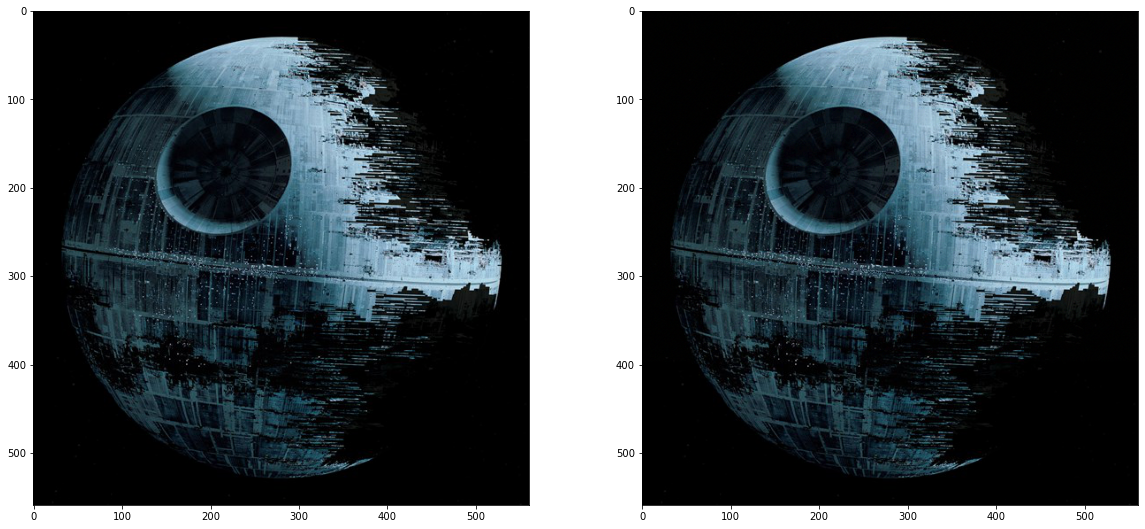

In [7]:
def CompareTwoImages(img1,img2):
    fig=plt.figure(figsize=(20, 20))

    fig.add_subplot(2, 2, 1)
    plt.imshow(img1)
    fig.add_subplot(2, 2, 2)
    plt.imshow(img2)

    plt.show()
CompareTwoImages(deathstar_img, encoded_img)

In [8]:
print(deathstar_img[200][200])
print(encoded_img[200][200])

[ 5  4 12]
[ 5  6 15]


*The DecodeImage function decodes and helps in retrieving the data hidden and prints it as the output.*

In [9]:
%%time
def DecodeImage(img):
    bit_message = ""
    bit_count = 0
    bit_length = 200
    for i,x in enumerate(img):
        for j,y in enumerate(x):
            for k,z in enumerate(y):
                zbits = '{0:08b}'.format(z)
                bit_message += zbits[-2:]
                bit_count += 2
                if bit_count == 80:
                    try:
                        decoded_tag = bitarray.bitarray(bit_message).tobytes().decode('utf-8')
                        bit_length = int(decoded_tag)+80
                        bit_message = ""
                    except:
                        print("Image does not have decode tag. Image is either not encoded or, at least, not encoded in a way this decoder recognizes")
                        return
                elif bit_count >= bit_length:
                    return bitarray.bitarray(bit_message).tobytes().decode('utf-8')

decoded_message = DecodeImage(encoded_img)
print(decoded_message[:1000])

THREEPIO: Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!  
 THREEPIO: We're doomed!  
 THREEPIO: There'll be no escape for the Princess this time.  
 THREEPIO: What's that?  
 THREEPIO: I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...  
 LUKE: Hurry up!  Come with me!  What are you waiting for?!  Get in gear!  
 THREEPIO: Artoo! Artoo-Detoo, where are you?  
 THREEPIO: At last!  Where have you been?  
 THREEPIO: They're heading in this direction. What are we going to do?  We'll be sent to the spice mines of Kessel or smashed into who knows what!  
 THREEPIO: Wait a minute, where are you going?  
 IMPERIAL: OFFICER The Death Star plans are not in the main computer.  
 VADER: Where are those transmissions you intercepted?  
 REBEL: OFFICER We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission.  
 VADER: If this is a consular ship... wh

In [10]:
print(decoded_message == All_SW_Scripts)

True


*The cover image is then saved.*

In [11]:
skimage.io.imsave("Death_Star_With_Scripts.jpg", encoded_img)

                                                                                                  *Project by Minal H. R and Rishika Satheesh.*